In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
# Create units for model
m = UNITS.meter
s = UNITS.seconds
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
K = UNITS.kelvin
C = UNITS.celsius
F = UNITS.fahrenheit
W = UNITS.watt
J = UNITS.joule
Pa = UNITS.pascal

<Unit('pascal')>

In [3]:
T_0 =  288 * K # 288 inital (326.84 neutral buoyant)
x_0 = 0 *m
y_0 = 0 * m
vx_0 = 0 * (m/s)
vy_0 = 0 * (m/s)

init = State(T=T_0,
            x=x_0,
            y=y_0,
            vx = vx_0,
            vy=vy_0)

,values
T,288 kelvin
x,0 meter
y,0 meter
vx,0 meter / second
vy,0 meter / second


In [4]:
system = System(init = init,
                g = -9.8 * m/s**2,
                mass = 613 * kg,   #210 F air (805 kg) + human (105 lb) + hot air balloon mass # 925.656 kg w air. MASS TOO HEAVY
                diameter = 12 * m,     #diameter of the hopper hot air balloon
                volume = 2200 * m**3,  #volume of hopper
                p_air = 1.2 * kg/m**3, #density (rho) of dry air
                coeff_d = 0.47,        #coefficient of drag
                area = 452.3893 * m**2,
                gas_constant = 287.05 * J/(kg * K),
                air_pressure = 101325 * Pa,       #cross sectional area of the hot air balloon
                t_0 = 0 *s,
                t_end = 500 * s)

,values
init,T 288 kelvin x 0 meter ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,12 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,452.3893 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [5]:
#def cool_func(state, system):
    
    #T, x, y, vx, vy = state
    #unpack(system)
    #T = -.256 * K + T
    #return T

def heat_func(state, system):
    
    T, x, y, vx, vy = state
    unpack(system)

    T = 1 *K + T
    return T

In [6]:
#cool_func(init, system)

In [7]:
#heat_func(init,system)

In [8]:
def density_in(state, system):
    unpack(system)
    T, x, y, vx, vy = state
    density_in = air_pressure / (gas_constant * T)
#     print(density_in.units)
    
    return density_in

In [9]:
density_in(init,system)

<Quantity(1.2256502932125644, 'kilogram * pascal / joule')>

In [10]:
def buoyant_force(state, system):
    """Computes buoyant force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    T, x, y, vx, vy = state
    unpack(system)
    
    d = Vector(0 * (m/s**2),-g)
    
    balloon_density = density_in(state,system)
#     print(p_air.units, balloon_density.units)
    f_b_mag = volume * (p_air - balloon_density) * d.mag
   # print(f_b_mag)
    direction = d.hat()
    f_b = direction * f_b_mag
    return f_b

In [11]:
buoyant_force(init, system)

<Quantity([  -0.         -553.02032166], 'kilogram * meter / second ** 2')>

In [12]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    T, x, y, vx, vy = state
    unpack(system)
    V = Vector(vx, vy)
    mag = p_air * V.mag**2 * coeff_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

In [13]:
drag_force(init,system)

<Quantity([0. 0.], 'kilogram * meter / second ** 2')>

In [14]:
def slope_func_heat(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system)
    
    
    dTdt = 1
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_buoyant
    #print(a_buoyant)
    #print(a_drag)
    #print(a_grav)
    #print(a)
    
    return dTdt, vx, vy, a.x, a.y

In [15]:
slope_func_heat(init, 0,system)

(1,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(0.0, 'meter / second ** 2')>,
 <Quantity(-10.702153868944354, 'meter / second ** 2')>)

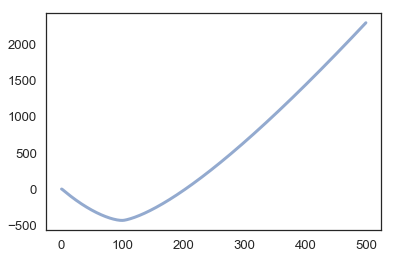

In [16]:
ts = linrange(system.t_0/s, system.t_end/s, 1)
results_heat, details = run_ode_solver(system, slope_func_heat, t_eval = ts)
plot(results_heat.y)

In [17]:
results_heat

,T,x,y,vx,vy
0.0,288.0,0.0,0.000000,0.0,0.000000
1.0,289.0,0.0,-4.062445,0.0,-6.444192
2.0,290.0,0.0,-10.950122,0.0,-7.048941
3.0,291.0,0.0,-18.000138,0.0,-7.036500
4.0,292.0,0.0,-25.011555,0.0,-6.990211
5.0,293.0,0.0,-31.975869,0.0,-6.935320
6.0,294.0,0.0,-38.890397,0.0,-6.879696
7.0,295.0,0.0,-45.750738,0.0,-6.835817
8.0,296.0,0.0,-52.560966,0.0,-6.791809
9.0,297.0,0.0,-59.322275,0.0,-6.744224


In [18]:
init2 = State(T=get_last_value(results_heat.T),
            x=get_last_value(results_heat.x),
            y=get_last_value(results_heat.y),
            vx = get_last_value(results_heat.vx),
            vy=get_last_value(results_heat.vy))

,values
T,787.000000
x,0.000000
y,2288.698015
vx,0.000000
vy,8.949576


In [19]:
system2 = System(init = init2,
                g = -9.8 * m/s**2,
                mass = 925.656 * kg,   #210 F air (805 kg) + human (105 lb) + hot air balloon mass
                diameter = 12 * m,     #diameter of the hopper hot air balloon
                volume = 850 * m**3,   #volume of hopper
                p_air = 1.2 * kg/m**3, #density (rho) of dry air
                coeff_d = 0.47,        #coefficient of drag
                area = 452.3893 * m**2,
                gas_constant = 287.05 * J/(kg * K),
                air_pressure = 101325 * Pa,       #cross sectional area of the hot air balloon
                t_0 = 500 * s, 
                t_end = 1000 * s)

,values
init,T 787.000000 x 0.000000 y 2288...
g,-9.8 meter / second ** 2
mass,925.656 kilogram
diameter,12 meter
volume,850 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,452.3893 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [20]:
def slope_func_cool(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system)
    
    
  
    dTdt = -0.256
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_buoyant
    #print(a_buoyant)
    #print(a_drag)
    #print(a)
    
    return dTdt, vx, vy, a.x, a.y

In [21]:
slope_func_cool(init, 0, system2)

(-0.256,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(0.0, 'meter / second ** 2')>,
 <Quantity(-10.030827588716178, 'meter / second ** 2')>)

,T,x,y,vx,vy
500.000000,787.000000,0.0,2288.698015,0.0,8.949576
500.089722,786.977031,0.0,2289.448169,0.0,7.811318
500.660155,786.831000,0.0,2292.554254,0.0,3.711906
501.432120,786.633377,0.0,2294.211609,0.0,0.807532
502.588470,786.337352,0.0,2293.159844,0.0,-2.455066
503.775454,786.033484,0.0,2289.085799,0.0,-4.106075
504.982638,785.724445,0.0,2283.780510,0.0,-4.568442
506.189823,785.415405,0.0,2278.186559,0.0,-4.671803
507.756743,785.014274,0.0,2270.838665,0.0,-4.696851
509.805538,784.489782,0.0,2261.206303,0.0,-4.702295


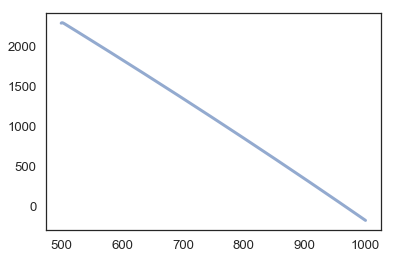

In [22]:
results_cool, details = run_ode_solver(system2, slope_func_cool)
plot(results_cool.y)
results_cool

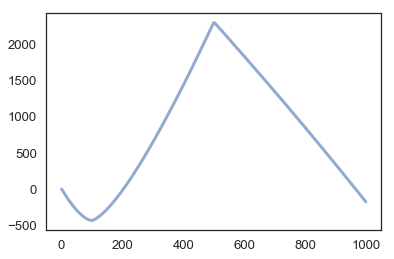

In [23]:
results = results_cool.combine_first(results_heat)
plot(results.y)

In [24]:
mass * g

<Quantity(-9071.4288, 'kilogram * meter / second ** 2')>

In [25]:
def error_func(T, system):
    unpack(system)
    state = init
    
    bouyant_force = buoyant_force(state, system)
    grav_force = mass * g
    
    return bouyant_force.y - grav_force
    

In [26]:
error_func(10000, system)

<Quantity(5454.379678337112, 'kilogram * meter / second ** 2')>

In [27]:
fsolve(error_func, 325,system)

C:\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([325.])

In [28]:
def burner_func(t):
    burner = int(((t+3)%6)/3)
    
    return burner

In [29]:
def dT_func(burner_func,t):
    
    burner = burner_func(t)
    T, x, y, vx, vy = state
    
    if burner == 1:
        dT = 1
        return dT 
    else:
        dT = -0.256
        return dT
    

In [30]:
int(2.56)

2

In [31]:
x = linspace(0, 10, 101)
y1 = (burner_func(i) for i in x)

<generator object <genexpr> at 0x000002AF25DA71A8>

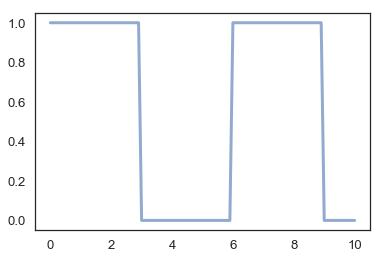

In [32]:
plot(x,y1)
